In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision import models, transforms, datasets
import torch.optim as optim
import os, pickle, time, copy, glob
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import argparse
import json



In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
#Using the transforms module in the torchvision module, we define a set of functions that perform data augmentation on our dataset to obtain more data.#
transformers = {'train_transforms' : transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
'test_transforms' : transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])}

trans = ['train_transforms','test_transforms']
path = "/content/gdrive/My Drive/Colab Notebooks/MainData/"
categories = ['train','test']

In [ ]:
dset = {x : torchvision.datasets.ImageFolder(path+x, transform=transformers[y]) for x,y in zip(categories, trans)}


In [ ]:
# creating training indices to be used for validation
len_train = len(dset['train'])
print('original train dataset size ', len_train) 
len_test = len(dset['test'])
print('original test dataset size ', len_test) 
#Insted of doing indices = list(range(num_train)), creating list in a different way
indices_list = range(len_train)
indices = [*indices_list]

#Shuffling the list of indices 
np.random.shuffle(indices)
#Splitting the indices based on train and val percentage
split = int(np.floor(0.2 * len_train))
train_idx, valid_idx = indices[split:], indices[:split]
print('Upadted train dataset size:', len(train_idx))
print('Created validation dataset size:', len(valid_idx))
test_idx = [i for i in range(len(dset['test']))]
print('the test imagedataest size', len(dset['test']))

#define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

dataset_sizes = {}
dataset_sizes['train'] = train_sampler.__len__()
dataset_sizes['test'] = test_sampler.__len__()
dataset_sizes['val'] = valid_sampler.__len__()
print(dataset_sizes['val'], dataset_sizes['test'], dataset_sizes['train'])


original train dataset size  2031
original test dataset size  3040
Upadted train dataset size: 1625
Created validation dataset size: 406
the test imagedataest size 3040
406 3040 1625


In [ ]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dset['train'], batch_size=16,
    drop_last= True, sampler=train_sampler, num_workers=0)
valid_loader = torch.utils.data.DataLoader(dset['train'], batch_size=16, 
    drop_last= True, sampler=valid_sampler, num_workers=0)
test_loader = torch.utils.data.DataLoader(dset['test'], batch_size=16, 
    drop_last= True,sampler=test_sampler,num_workers=0)


In [ ]:
dataloaders = {'train':train_loader,'val':valid_loader,'test':test_loader}
#https://github.com/bonn0062/image_classifier_pytorch/blob/master/PyTorch_Image_Classifier.ipynb
class_names = dset['train'].classes

In [ ]:
# Label mapping
#with open('/content/gdrive/My Drive/Colab Notebooks/cat_to_name.json', 'r') as f:
    #cat_to_name = json.load(f)

In [ ]:
images, labels = next(iter(dataloaders['test']))
rand_idx = np.random.randint(len(images))
# print(rand_idx)
print("label: {}, class: {}".format(labels[rand_idx].item(),
                                               class_names[labels[rand_idx].item()]))

label: 0, class: covid-n


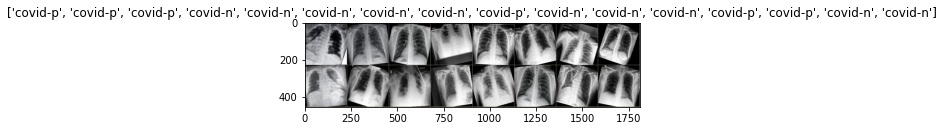

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
inputs,classes = next(iter(dataloaders["train"]))
out = torchvision.utils.make_grid(inputs)
class_names = dset["train"].classes
imshow(out, title = [class_names[x] for x in classes])


In [ ]:
class ModelRestnet(nn.Module):
    def __init__(self):
        super(ModelRestnet, self).__init__()
        #obtain the ResNet model from torchvision.model library
        self.model = torchvision.models.resnet18(pretrained=True)
        #build our classifier and since we are classifying the images into NORMAL and COVID, we output a two-dimensional tensor.
        self.classifier = nn.Sequential(
        nn.Linear(self.model.fc.in_features,2),
        nn.LogSoftmax(dim=1))
        #Requires_grad = False denies the ResNet model the ability to update its parameters hence make it unable to train.
        for params in self.model.parameters():
            params.requires_grad = False
            #We replace the fully connected layers of the base model(ResNet model) which served as the classifier with our custom trainable classifier.
        self.model.fc = self.classifier

    def forward(self, x):
        # x is our input data
        return self.model(x)
        
#we instantiate our model class
model = ModelRestnet()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []
def fit(self, dataloaders, num_epochs):

        #we check whether a gpu is enabled for our environment.
        train_on_gpu = torch.cuda.is_available()
        #we define our optimizer and pass in the model parameters(weights and biases) into the constructor of the optimizer we want. More info: https://pytorch.org/docs/stable/optim.html
        optimizer = optimizer = optim.Adam(self.model.parameters(), lr=0.01 )
        #Essentially what scheduler does is to reduce our learning by a certain factor when less progress is being made in our training.
        scheduler = optim.lr_scheduler.StepLR(optimizer, 4)
        #criterion is the loss function of our model. we use Negative Log-Likelihood loss because we used  log-softmax as the last layer of our model. We can remove the log-softmax layer and replace the nn.NLLLoss() with nn.CrossEntropyLoss()
        criterion = nn.NLLLoss()
        since = time.time()
        #model.state_dict() is a dictionary of our model's parameters. What we did here is to deepcopy it and assign it to a variable
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
      #we check if a gpu is enabled for our environment and move our model to the gpu
        if train_on_gpu:
            self.model = self.model.cuda()
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
            # Each epoch has a training and validation phase. We iterate through the training set and validation set in every epoch.
            for phase in ['train', 'val']:
                #we apply the scheduler to the learning rate in the training phase since we don't train our model in the validation phase
                if phase == 'train':
                    scheduler.step()
                    self.model.train()  # Set model to training mode
                else:
                    self.model.eval()   # Set model to evaluate mode to turn off features like dropout.
                running_loss = 0.0
                running_corrects = 0
                # Iterate over batches of train and validation data.
                for inputs, labels in dataloaders[phase]:
                    if train_on_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    # clear all gradients since gradients get accumulated after every iteration.
                    optimizer.zero_grad()
                    
                    # track history if only in training phase
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        #calculates the loss between the output of our model and ground-truth labels
                        loss = criterion(outputs, labels)

                        # perform backpropagation and optimization only if in training phase
                        if phase == 'train':
                            #backpropagate gradients from the loss node through all the parameters
                            loss.backward()
                            #Update parameters(Weighs and biases) of our model using the gradients.
                            optimizer.step()
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
#https://colab.research.google.com/github/sanchit2843/MLBasics/blob/master/IntelClassificationKaggle/Pytorch%20transfer%20learning%20tutorial%20%5B93%25acc%5D.ipynb#scrollTo=zkvZWnE_bi4Z
                if(phase == 'train'):
                  train_losses.append(epoch_loss)   
                  train_acc.append(epoch_acc) 
                if(phase == 'val'):
                  val_losses.append(epoch_loss)   
                  val_acc.append(epoch_acc) 
                # deep copy the model if we obtain a better validation accuracy than the previous one.
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))
        
        # load best model parameters and return it as the final trained model.
        self.model.load_state_dict(best_model_wts)
        return self.model


In [ ]:
num_epochs = 5
model1_restnet = fit(model, dataloaders, num_epochs)

Epoch 0/4
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1740 Acc: 0.9822
val Loss: 0.1085 Acc: 0.9507
Epoch 1/4
----------
train Loss: 0.0355 Acc: 0.9852
val Loss: 0.0189 Acc: 0.9803
Epoch 2/4
----------
train Loss: 0.0358 Acc: 0.9828
val Loss: 0.0183 Acc: 0.9803
Epoch 3/4
----------
train Loss: 0.0151 Acc: 0.9908
val Loss: 0.0156 Acc: 0.9803
Epoch 4/4
----------
train Loss: 0.0129 Acc: 0.9883
val Loss: 0.0079 Acc: 0.9852
Training complete in 10m 3s
Best val Acc: 0.985222


In [ ]:
model1_restnet.eval()
torch.save(model1_restnet, '/content/gdrive/My Drive/Colab Notebooks/restnet18_model1_without_aug.pt')

In [ ]:
num_epochs = 10
model2_restnet = fit(model, dataloaders, num_epochs)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.0860 Acc: 0.9822
val Loss: 0.0142 Acc: 0.9778
Epoch 1/9
----------
train Loss: 0.0683 Acc: 0.9846
val Loss: 0.1643 Acc: 0.9655
Epoch 2/9
----------
train Loss: 0.0718 Acc: 0.9840
val Loss: 0.0428 Acc: 0.9680
Epoch 3/9
----------
train Loss: 0.0148 Acc: 0.9908
val Loss: 0.0134 Acc: 0.9803
Epoch 4/9
----------
train Loss: 0.0059 Acc: 0.9932
val Loss: 0.0076 Acc: 0.9828
Epoch 5/9
----------
train Loss: 0.0046 Acc: 0.9932
val Loss: 0.0330 Acc: 0.9803
Epoch 6/9
----------
train Loss: 0.0051 Acc: 0.9914
val Loss: 0.0488 Acc: 0.9803
Epoch 7/9
----------
train Loss: 0.0094 Acc: 0.9926
val Loss: 0.0014 Acc: 0.9852
Epoch 8/9
----------
train Loss: 0.0113 Acc: 0.9908
val Loss: 0.0216 Acc: 0.9778
Epoch 9/9
----------
train Loss: 0.0084 Acc: 0.9895
val Loss: 0.0086 Acc: 0.9828
Training complete in 3m 23s
Best val Acc: 0.985222


In [ ]:
model2_restnet.eval()
torch.save(model2_restnet, '/content/gdrive/My Drive/Colab Notebooks/restnet18_model2_without_aug.pt')

In [ ]:
num_epochs = 15
model3_restnet = fit(model, dataloaders, num_epochs)

Epoch 0/14
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1157 Acc: 0.9815
val Loss: 0.0462 Acc: 0.9754
Epoch 1/14
----------
train Loss: 0.0217 Acc: 0.9889
val Loss: 0.0330 Acc: 0.9803
Epoch 2/14
----------
train Loss: 0.0274 Acc: 0.9877
val Loss: 0.0030 Acc: 0.9852
Epoch 3/14
----------
train Loss: 0.0030 Acc: 0.9932
val Loss: 0.0148 Acc: 0.9803
Epoch 4/14
----------
train Loss: 0.0039 Acc: 0.9932
val Loss: 0.0167 Acc: 0.9803
Epoch 5/14
----------
train Loss: 0.0031 Acc: 0.9920
val Loss: 0.0153 Acc: 0.9729
Epoch 6/14
----------
train Loss: 0.0049 Acc: 0.9920
val Loss: 0.0284 Acc: 0.9778
Epoch 7/14
----------
train Loss: 0.0058 Acc: 0.9920
val Loss: 0.0210 Acc: 0.9803
Epoch 8/14
----------
train Loss: 0.0019 Acc: 0.9932
val Loss: 0.0202 Acc: 0.9803
Epoch 9/14
----------
train Loss: 0.0040 Acc: 0.9932
val Loss: 0.0127 Acc: 0.9803
Epoch 10/14
----------
train Loss: 0.0007 Acc: 0.9945
val Loss: 0.0031 Acc: 0.9852
Epoch 11/14
----------
train Loss: 0.0023 Acc: 0.9938
val Loss: 0.0277 Acc: 0.9803
Epoch 12/14
----------
train Loss: 0

In [ ]:
model3_restnet.eval()
torch.save(model3_restnet, '/content/gdrive/My Drive/Colab Notebooks/restnet18_model3_without_aug.pt')

In [ ]:
num_epochs = 20
model4_restnet = fit(model, dataloaders, num_epochs)

Epoch 0/19
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.0122 Acc: 0.9908
val Loss: 0.0208 Acc: 0.9778
Epoch 1/19
----------
train Loss: 0.0207 Acc: 0.9908
val Loss: 0.0271 Acc: 0.9803
Epoch 2/19
----------
train Loss: 0.0117 Acc: 0.9920
val Loss: 0.0237 Acc: 0.9803
Epoch 3/19
----------
train Loss: 0.0082 Acc: 0.9926
val Loss: 0.0265 Acc: 0.9803
Epoch 4/19
----------
train Loss: 0.0071 Acc: 0.9908
val Loss: 0.0557 Acc: 0.9803
Epoch 5/19
----------
train Loss: 0.0079 Acc: 0.9914
val Loss: 0.0330 Acc: 0.9778
Epoch 6/19
----------
train Loss: 0.0008 Acc: 0.9945
val Loss: 0.0430 Acc: 0.9803
Epoch 7/19
----------
train Loss: 0.0069 Acc: 0.9926
val Loss: 0.0220 Acc: 0.9828
Epoch 8/19
----------
train Loss: 0.0039 Acc: 0.9932
val Loss: 0.0093 Acc: 0.9828
Epoch 9/19
----------
train Loss: 0.0066 Acc: 0.9926
val Loss: 0.0070 Acc: 0.9828
Epoch 10/19
----------
train Loss: 0.0124 Acc: 0.9908
val Loss: 0.0205 Acc: 0.9803
Epoch 11/19
----------
train Loss: 0.0012 Acc: 0.9938
val Loss: 0.0323 Acc: 0.9803
Epoch 12/19
----------
train Loss: 0

In [ ]:
model4_restnet.eval()
torch.save(model4_restnet, '/content/gdrive/My Drive/Colab Notebooks/restnet18_model4_without_aug.pt')

In [ ]:
num_epochs = 25
model5_restnet = fit(model, dataloaders, num_epochs)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.0484 Acc: 0.9871
val Loss: 0.0542 Acc: 0.9803
Epoch 1/24
----------
train Loss: 0.0125 Acc: 0.9914
val Loss: 0.0766 Acc: 0.9803
Epoch 2/24
----------
train Loss: 0.0222 Acc: 0.9902
val Loss: 0.0248 Acc: 0.9803
Epoch 3/24
----------
train Loss: 0.0077 Acc: 0.9920
val Loss: 0.0110 Acc: 0.9828
Epoch 4/24
----------
train Loss: 0.0096 Acc: 0.9914
val Loss: 0.0398 Acc: 0.9803
Epoch 5/24
----------
train Loss: 0.0074 Acc: 0.9926
val Loss: 0.0197 Acc: 0.9828
Epoch 6/24
----------
train Loss: 0.0055 Acc: 0.9938
val Loss: 0.0210 Acc: 0.9803
Epoch 7/24
----------
train Loss: 0.0069 Acc: 0.9920
val Loss: 0.0304 Acc: 0.9803
Epoch 8/24
----------
train Loss: 0.0051 Acc: 0.9926
val Loss: 0.0117 Acc: 0.9803
Epoch 9/24
----------
train Loss: 0.0046 Acc: 0.9926
val Loss: 0.0278 Acc: 0.9803
Epoch 10/24
----------
train Loss: 0.0003 Acc: 0.9945
val Loss: 0.0424 Acc: 0.9778
Epoch 11/24
----------
train Loss: 0.0052 Acc: 0.9926
val Loss: 0.0248 Acc: 0.9778
Epoch 12/24
----------
train Loss: 0

In [ ]:
model5_restnet.eval()
torch.save(model5_restnet, '/content/gdrive/My Drive/Colab Notebooks/restnet18_model5_without_aug.pt')